In [1]:
# Imports
import torch
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F 
from torch import nn 
import torchvision.datasets as datasets
from torch.utils.data import Dataset 
from torch.utils.data import random_split 
import torchvision.transforms as transforms 
import os
import shutil
import numpy as np
import pandas as pd
from torchvision.io import read_image
from torch import optim
from torch.utils.data import DataLoader 
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from tqdm import tqdm 
from sklearn import metrics

from dataGen import Patches
from ResNet_75.ResNet_75 import ResNet_75 as CNN
from PIL import Image
import spectral as spec

E:\Software\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Custom image dataset

class Img(Dataset):
    def __init__(self, img_df, transform=None):
        self.img_df = img_df
        self.transform = transform

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        img_path = self.img_df['path'].iloc[idx]
        img = spec.envi.open(img_path)
        np_img = np.array(img[:, :, :])
        label = self.img_df['class'].iloc[idx]
        if self.transform:
            image = self.transform(np_img)
        return image, label

In [3]:
def tensorToImg(tensor, img_size):
    img = torch.zeros(img_size, img_size, 1)
    for c_y, y in enumerate(tensor[0]):
        for c_x, x in enumerate(y):
            img[c_y][c_x] = x
    return img

In [4]:
def displayImgs(imgs, labels, img_size, save=False):
    fig = plt.figure(figsize=(20,11))
    for pos, i in enumerate(imgs[:8]):
        img = tensorToImg(i, img_size)
        label = "downy mildew"
        if labels[pos] == 0:
            label = "Non-disease"
        fig.add_subplot(4, 8, pos + 1).title.set_text(label)
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.2)
    plt.show()
    if save:
        fig.savefig('fig.png')

In [5]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count()

1

In [6]:
# Hyperparameters

in_channels = 75
num_classes = 3
img_size = 12
learning_rate = 0.0001
batch_size = 32
num_epochs = 60
frac = .7

In [7]:
# Transformers

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.ConvertImageDtype(torch.float)])
img_transform

Compose(
    ToTensor()
    Resize(size=(12, 12), interpolation=bilinear)
    ConvertImageDtype()
)

In [8]:
# Init dataset

patch_14 = Patches("D:\\gyeongsang_22_10_14\\PATCHES")
patch_21 = Patches("D:\\gyeongsang_22_10_21_1\\PATCHES")
patch_25 = Patches("D:\\gyeongsang_22_10_25\\PATCHES")
patch_28 = Patches("D:\\gyeongsang_22_10_28\\PATCHES")

In [9]:
print(patch_14.describe(),
      patch_21.describe(),
      patch_25.describe(),
      patch_28.describe())

For hdr image, there are: 
 background    1178
leaf           820
diseased        98
Name: class, dtype: int64
For jpg image, there are: 
 background    1178
leaf           820
diseased        98
Name: class, dtype: int64
For hdr image, there are: 
 background    791
leaf          628
diseased       86
Name: class, dtype: int64
For jpg image, there are: 
 background    791
leaf          628
diseased       86
Name: class, dtype: int64
For hdr image, there are: 
 leaf          267
background    266
diseased       68
Name: class, dtype: int64
For jpg image, there are: 
 leaf          267
background    266
diseased       68
Name: class, dtype: int64
For hdr image, there are: 
 background    793
leaf          627
diseased      189
Name: class, dtype: int64
For jpg image, there are: 
 background    793
leaf          627
diseased      189
Name: class, dtype: int64
None None None None


In [10]:
def getDataset(patch, dc, train_frac = .7):
    patch_ds = patch.generateAndSplitDataset(
        dataset_composition = [
            ['diseased',    dc[0]],
            ['leaf',        dc[1]],
            ['background',  dc[2]]],
        data_type = 'hdr',
        train_frac = train_frac)
    for p in patch_ds:
        p.loc[(p['class'] == 'background'), 'class'] = 0
        p.loc[(p['class'] == 'leaf'), 'class'] = 1
        p.loc[(p['class'] == 'diseased'), 'class'] = 2

        print(p.describe())
    
    return patch_ds

In [11]:
patch_14_ds = getDataset(patch_14, [98, 820, 1178], train_frac = .3)
patch_21_ds = getDataset(patch_21, [86, 628, 791], train_frac = .3)
patch_25_ds = getDataset(patch_25, [68, 266, 266], train_frac = .3)
patch_28_ds = getDataset(patch_28, [189, 627, 793])

                                                     path type  class
count                                                 628  628    628
unique                                                628    1      3
top     D:\gyeongsang_22_10_14\PATCHES\STACK_75_BANDS_...  hdr      0
freq                                                    1  628    353
                                                     path  type  class
count                                                1468  1468   1468
unique                                               1468     1      3
top     D:\gyeongsang_22_10_14\PATCHES\STACK_75_BANDS_...   hdr      0
freq                                                    1  1468    825
                                                     path type  class
count                                                 451  451    451
unique                                                451    1      3
top     D:\gyeongsang_22_10_21_1\PATCHES\STACK_75_BAND...  hdr      0
freq           

In [12]:
train_patch = pd.concat([patch_14_ds[0], patch_21_ds[0], patch_25_ds[0], patch_28_ds[0]])
val_patch = pd.concat([patch_14_ds[1], patch_21_ds[1], patch_25_ds[1], patch_28_ds[1]])
# train_patch = patch_28_ds[0]
# val_patch = patch_28_ds[1]

In [13]:
patch_28_ds[0].to_csv("train_new.csv")
patch_28_ds[1].to_csv("val_new.csv")

In [14]:
train_dataset = Img(img_df=train_patch, transform=img_transform)
val_dataset = Img(img_df=val_patch, transform=img_transform)

print(f"The num of training dataset is {len(train_dataset)} and num of validation dataset is {len(val_dataset)}")

The num of training dataset is 2385 and num of validation dataset is 3425


In [15]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

In [16]:
next(iter(train_loader))[0].shape

torch.Size([32, 75, 12, 12])

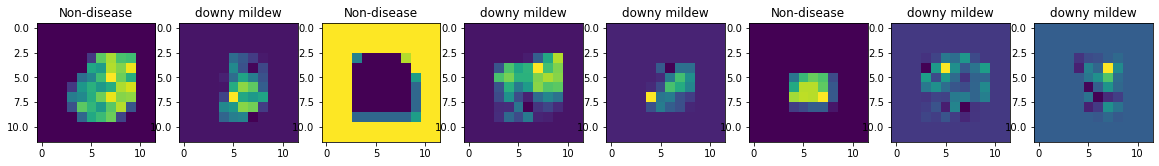

In [17]:
# Check the images

for train_sample in train_loader:
    displayImgs(train_sample[0], train_sample[1], img_size, save=True)
    break

In [18]:
# Initialize network

model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

In [19]:
# Loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
# Check the model

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        x_ = model(x)
        print(x_[0])
        break

tensor([-0.5304,  0.4038, -0.1078], device='cuda:0')


In [21]:
# Check accuracy on training & test to see how good our model

def evaluate(loader, model):
    ev = np.zeros(5)
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
                        
            y = y.cpu()
            predictions = predictions.cpu()
                        
            ev[0] += 1
            ev[1] += precision_score(y, predictions, average='micro')
            ev[2] += recall_score(y, predictions, average='micro')
            ev[3] += f1_score(y, predictions, average='micro')
            ev[4] += accuracy_score(y, predictions)
            
        ev = ev/ev[0]
        
    model.train()
    return ev*100

print(f"Accuracy on training set: {evaluate(train_loader, model)}")
print(f"Accuracy on test set: {evaluate(test_loader, model)}")

Accuracy on training set: [100.          17.65686275  17.65686275  17.65686275  17.65686275]
Accuracy on test set: [100.          16.95601852  16.95601852  16.95601852  16.95601852]


In [22]:
# Make a list to record training progress

history_test = [[] for l in range(6)]
history_train = [[] for l in range(6)]

In [23]:
# Train the network

for epoch in range(num_epochs):
    batch_loss = np.array([])
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, targets) in loop:
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        predictions = torch.argmax(scores, dim=1)
               
        #update progess bar
        loop.set_description(f"Epoch[{epoch}/{num_epochs - 1}]")
        
        batch_loss = np.append(batch_loss, loss.item())
    
    history_train[5].append(np.average(batch_loss))
    evaluation_test = evaluate(test_loader, model)
    evaluation_train = evaluate(train_loader, model)
    for i in range(5):
        history_test[i].append(evaluation_test[i])
        history_train[i].append(evaluation_train[i])
        
    print(f"loss: {history_train[5][-1]}\n precision: {history_test[1][-1]}\n recall: {history_test[2][-1]}\n f1 score: {history_test[3][-1]}\n accuracy: {history_test[4][-1]}")

Epoch[0/59]: 100%|█████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.12it/s]


loss: 0.41427690625190733
 precision: 89.95949074074075
 recall: 89.95949074074075
 f1 score: 89.95949074074075
 accuracy: 89.95949074074075


Epoch[1/59]: 100%|█████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.48it/s]


loss: 0.33616247336069743
 precision: 90.2199074074074
 recall: 90.2199074074074
 f1 score: 90.2199074074074
 accuracy: 90.2199074074074


Epoch[2/59]: 100%|█████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.69it/s]


loss: 0.33607383956511816
 precision: 89.90162037037037
 recall: 89.90162037037037
 f1 score: 89.90162037037037
 accuracy: 89.90162037037037


Epoch[3/59]: 100%|█████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.47it/s]


loss: 0.31219893554846445
 precision: 89.98842592592592
 recall: 89.98842592592592
 f1 score: 89.98842592592592
 accuracy: 89.98842592592592


Epoch[4/59]: 100%|█████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.68it/s]


loss: 0.30730259567499163
 precision: 90.33564814814815
 recall: 90.33564814814815
 f1 score: 90.33564814814815
 accuracy: 90.33564814814815


Epoch[5/59]: 100%|█████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.44it/s]


loss: 0.3020738635460536
 precision: 89.67013888888889
 recall: 89.67013888888889
 f1 score: 89.67013888888889
 accuracy: 89.67013888888889


Epoch[6/59]: 100%|█████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.58it/s]


loss: 0.299492581586043
 precision: 89.23611111111111
 recall: 89.23611111111111
 f1 score: 89.23611111111111
 accuracy: 89.23611111111111


Epoch[7/59]: 100%|█████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.48it/s]


loss: 0.267655267616113
 precision: 89.49652777777779
 recall: 89.49652777777779
 f1 score: 89.49652777777779
 accuracy: 89.49652777777779


Epoch[8/59]: 100%|█████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.18it/s]


loss: 0.23963283906380337
 precision: 86.16898148148148
 recall: 86.16898148148148
 f1 score: 86.16898148148148
 accuracy: 86.16898148148148


Epoch[9/59]: 100%|█████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.43it/s]


loss: 0.2329066366950671
 precision: 89.32291666666666
 recall: 89.32291666666666
 f1 score: 89.32291666666666
 accuracy: 89.32291666666666


Epoch[10/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.99it/s]


loss: 0.20498178939024608
 precision: 89.67013888888889
 recall: 89.67013888888889
 f1 score: 89.67013888888889
 accuracy: 89.67013888888889


Epoch[11/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.45it/s]


loss: 0.2225911271572113
 precision: 89.4675925925926
 recall: 89.4675925925926
 f1 score: 89.4675925925926
 accuracy: 89.4675925925926


Epoch[12/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.49it/s]


loss: 0.1834793284535408
 precision: 84.49074074074075
 recall: 84.49074074074075
 f1 score: 84.49074074074075
 accuracy: 84.49074074074075


Epoch[13/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.51it/s]


loss: 0.16563116510709128
 precision: 83.68055555555556
 recall: 83.68055555555556
 f1 score: 83.68055555555556
 accuracy: 83.68055555555556


Epoch[14/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.47it/s]


loss: 0.1402660118540128
 precision: 89.35185185185185
 recall: 89.35185185185185
 f1 score: 89.35185185185185
 accuracy: 89.35185185185185


Epoch[15/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.47it/s]


loss: 0.1254419776548942
 precision: 84.80902777777779
 recall: 84.80902777777779
 f1 score: 84.80902777777779
 accuracy: 84.80902777777779


Epoch[16/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.36it/s]


loss: 0.11429331603149573
 precision: 86.89236111111111
 recall: 86.89236111111111
 f1 score: 86.89236111111111
 accuracy: 86.89236111111111


Epoch[17/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.69it/s]


loss: 0.09853590356806914
 precision: 88.94675925925925
 recall: 88.94675925925925
 f1 score: 88.94675925925925
 accuracy: 88.94675925925925


Epoch[18/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.50it/s]


loss: 0.08625225094457467
 precision: 88.54166666666666
 recall: 88.54166666666666
 f1 score: 88.54166666666666
 accuracy: 88.54166666666666


Epoch[19/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 13.79it/s]


loss: 0.053560994441310565
 precision: 88.25231481481481
 recall: 88.25231481481481
 f1 score: 88.25231481481481
 accuracy: 88.25231481481481


Epoch[20/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.50it/s]


loss: 0.05314055444051822
 precision: 89.49652777777779
 recall: 89.49652777777779
 f1 score: 89.49652777777779
 accuracy: 89.49652777777779


Epoch[21/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.55it/s]


loss: 0.0366036595714589
 precision: 87.55787037037037
 recall: 87.55787037037037
 f1 score: 87.55787037037037
 accuracy: 87.55787037037037


Epoch[22/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.85it/s]


loss: 0.03649743244362374
 precision: 88.94675925925925
 recall: 88.94675925925925
 f1 score: 88.94675925925925
 accuracy: 88.94675925925925


Epoch[23/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.02it/s]


loss: 0.015977919353172183
 precision: 87.76041666666666
 recall: 87.76041666666666
 f1 score: 87.76041666666666
 accuracy: 87.76041666666666


Epoch[24/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.26it/s]


loss: 0.016996579946329197
 precision: 87.52893518518519
 recall: 87.52893518518519
 f1 score: 87.52893518518519
 accuracy: 87.52893518518519


Epoch[25/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.90it/s]


loss: 0.012938354392535984
 precision: 87.06597222222221
 recall: 87.06597222222221
 f1 score: 87.06597222222221
 accuracy: 87.06597222222221


Epoch[26/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.04it/s]


loss: 0.008229499392521877
 precision: 88.10763888888889
 recall: 88.10763888888889
 f1 score: 88.10763888888889
 accuracy: 88.10763888888889


Epoch[27/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.11it/s]


loss: 0.008219948685728014
 precision: 88.36805555555556
 recall: 88.36805555555556
 f1 score: 88.36805555555556
 accuracy: 88.36805555555556


Epoch[28/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.60it/s]


loss: 0.008720887132609883
 precision: 88.28125
 recall: 88.28125
 f1 score: 88.28125
 accuracy: 88.28125


Epoch[29/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.97it/s]


loss: 0.011998327088852723
 precision: 88.59953703703704
 recall: 88.59953703703704
 f1 score: 88.59953703703704
 accuracy: 88.59953703703704


Epoch[30/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.88it/s]


loss: 0.007947046473467102
 precision: 88.83101851851852
 recall: 88.83101851851852
 f1 score: 88.83101851851852
 accuracy: 88.83101851851852


Epoch[31/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 12.37it/s]


loss: 0.003950322185798238
 precision: 88.6863425925926
 recall: 88.6863425925926
 f1 score: 88.6863425925926
 accuracy: 88.6863425925926


Epoch[32/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.91it/s]


loss: 0.0025449739086131256
 precision: 88.59953703703704
 recall: 88.59953703703704
 f1 score: 88.59953703703704
 accuracy: 88.59953703703704


Epoch[33/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.08it/s]


loss: 0.0023285945190582424
 precision: 88.22337962962963
 recall: 88.22337962962963
 f1 score: 88.22337962962963
 accuracy: 88.22337962962963


Epoch[34/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.31it/s]


loss: 0.0018602900315696994
 precision: 88.48379629629629
 recall: 88.48379629629629
 f1 score: 88.48379629629629
 accuracy: 88.48379629629629


Epoch[35/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.60it/s]


loss: 0.0016507997765438632
 precision: 88.25231481481481
 recall: 88.25231481481481
 f1 score: 88.25231481481481
 accuracy: 88.25231481481481


Epoch[36/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.74it/s]


loss: 0.0015151818034549553
 precision: 88.02083333333334
 recall: 88.02083333333334
 f1 score: 88.02083333333334
 accuracy: 88.02083333333334


Epoch[37/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.11it/s]


loss: 0.001481844832887873
 precision: 88.48379629629629
 recall: 88.48379629629629
 f1 score: 88.48379629629629
 accuracy: 88.48379629629629


Epoch[38/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.24it/s]


loss: 0.0010741907598761221
 precision: 88.22337962962963
 recall: 88.22337962962963
 f1 score: 88.22337962962963
 accuracy: 88.22337962962963


Epoch[39/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.65it/s]


loss: 0.0012648349592927844
 precision: 87.99189814814815
 recall: 87.99189814814815
 f1 score: 87.99189814814815
 accuracy: 87.99189814814815


Epoch[40/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.57it/s]


loss: 0.0013255411456339062
 precision: 88.77314814814815
 recall: 88.77314814814815
 f1 score: 88.77314814814815
 accuracy: 88.77314814814815


Epoch[41/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 13.07it/s]


loss: 0.001112203459100177
 precision: 88.62847222222221
 recall: 88.62847222222221
 f1 score: 88.62847222222221
 accuracy: 88.62847222222221


Epoch[42/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.98it/s]


loss: 0.001000624140142463
 precision: 88.85995370370371
 recall: 88.85995370370371
 f1 score: 88.85995370370371
 accuracy: 88.85995370370371


Epoch[43/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.04it/s]


loss: 0.0007872122902578363
 precision: 88.59953703703704
 recall: 88.59953703703704
 f1 score: 88.59953703703704
 accuracy: 88.59953703703704


Epoch[44/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.90it/s]


loss: 0.0007859053211480689
 precision: 88.25231481481481
 recall: 88.25231481481481
 f1 score: 88.25231481481481
 accuracy: 88.25231481481481


Epoch[45/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.13it/s]


loss: 0.000739392803516239
 precision: 88.77314814814815
 recall: 88.77314814814815
 f1 score: 88.77314814814815
 accuracy: 88.77314814814815


Epoch[46/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.14it/s]


loss: 0.000644475925170506
 precision: 88.83101851851852
 recall: 88.83101851851852
 f1 score: 88.83101851851852
 accuracy: 88.83101851851852


Epoch[47/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.01it/s]


loss: 0.000656754247029312
 precision: 88.54166666666666
 recall: 88.54166666666666
 f1 score: 88.54166666666666
 accuracy: 88.54166666666666


Epoch[48/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.60it/s]


loss: 0.0007351843628566712
 precision: 87.06597222222221
 recall: 87.06597222222221
 f1 score: 87.06597222222221
 accuracy: 87.06597222222221


Epoch[49/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.49it/s]


loss: 0.0005276531029570227
 precision: 88.85995370370371
 recall: 88.85995370370371
 f1 score: 88.85995370370371
 accuracy: 88.85995370370371


Epoch[50/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.59it/s]


loss: 0.0005652556611069788
 precision: 88.25231481481481
 recall: 88.25231481481481
 f1 score: 88.25231481481481
 accuracy: 88.25231481481481


Epoch[51/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.56it/s]


loss: 0.0006123827682070744
 precision: 88.33912037037037
 recall: 88.33912037037037
 f1 score: 88.33912037037037
 accuracy: 88.33912037037037


Epoch[52/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.64it/s]


loss: 0.0006033819100897138
 precision: 87.84722222222221
 recall: 87.84722222222221
 f1 score: 87.84722222222221
 accuracy: 87.84722222222221


Epoch[53/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.70it/s]


loss: 0.0005144595902917596
 precision: 88.71527777777779
 recall: 88.71527777777779
 f1 score: 88.71527777777779
 accuracy: 88.71527777777779


Epoch[54/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.17it/s]


loss: 0.00047469361132243646
 precision: 88.57060185185185
 recall: 88.57060185185185
 f1 score: 88.57060185185185
 accuracy: 88.57060185185185


Epoch[55/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.69it/s]


loss: 0.00035530377509227645
 precision: 88.07870370370371
 recall: 88.07870370370371
 f1 score: 88.07870370370371
 accuracy: 88.07870370370371


Epoch[56/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.44it/s]


loss: 0.000294793759045812
 precision: 88.42592592592592
 recall: 88.42592592592592
 f1 score: 88.42592592592592
 accuracy: 88.42592592592592


Epoch[57/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.75it/s]


loss: 0.0003607012658903841
 precision: 88.57060185185185
 recall: 88.57060185185185
 f1 score: 88.57060185185185
 accuracy: 88.57060185185185


Epoch[58/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.23it/s]


loss: 0.0003922933342983015
 precision: 88.51273148148148
 recall: 88.51273148148148
 f1 score: 88.51273148148148
 accuracy: 88.51273148148148


Epoch[59/59]: 100%|████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.59it/s]


loss: 0.0002749358566021935
 precision: 88.36805555555556
 recall: 88.36805555555556
 f1 score: 88.36805555555556
 accuracy: 88.36805555555556


In [25]:
def smooth(y, box_pts):
    y = [y[0] for i in range(box_pts)] + y + [y[-1] for i in range(box_pts)]
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth[box_pts: -box_pts]

In [ ]:
pd_htrain = pd.DataFrame(history_train)
pd_htrain = pd_htrain.T
pd_htrain.to_csv('history_train.csv')

pd_htest = pd.DataFrame(history_test)
pd_htest = pd_htest.T
pd_htest.to_csv('history_test.csv')  

In [26]:
import copy
smooth_f = 50

In [27]:
smooth_h_test = copy.deepcopy(history_test)
smooth_h_train = copy.deepcopy(history_train)

In [28]:
for i in range(len(smooth_h_train)):
    if len(smooth_h_train[i]) > 0:
        smooth_h_train[i] = smooth(smooth_h_train[i], smooth_f)
    if len(smooth_h_test[i]) > 0:
        smooth_h_test[i] = smooth(smooth_h_test[i], smooth_f)

In [ ]:
with open('smooth_h_train.txt', 'w') as fp:
    for item in smooth_h_train:
        fp.write("%s\n" % item)
    print('Done')

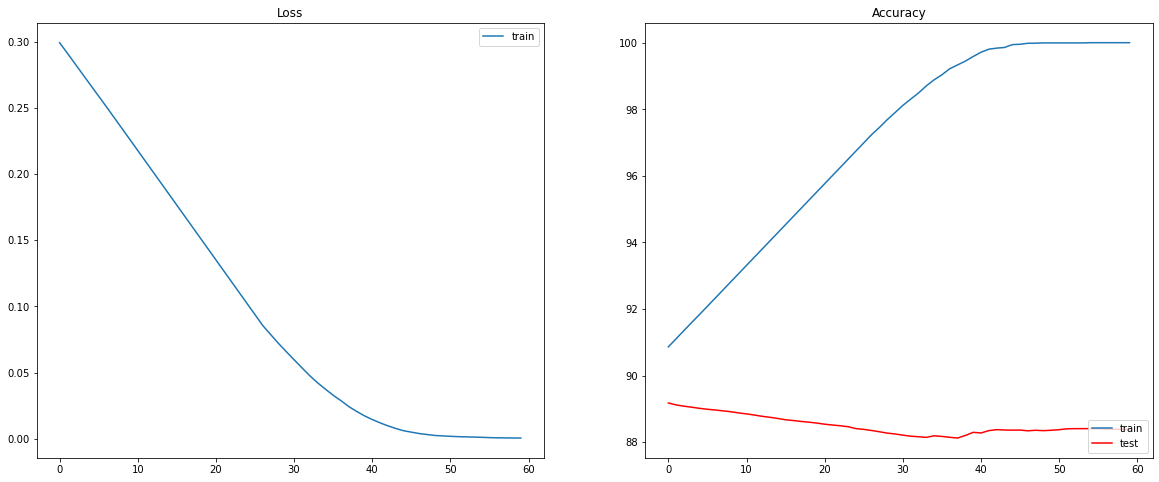

In [29]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,8))
epochs = [e for e in range(num_epochs)]

ax1.set_title('Loss')
ax2.set_title('Accuracy')

ax1.plot(epochs, smooth_h_train[5], label='train')
ax2.plot(epochs, smooth_h_train[4], label='train')
ax2.plot(epochs, smooth_h_test[4], 'r', label='test')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

In [ ]:
fig.savefig('evaluation2.png')

In [53]:
torch.save(model.state_dict(), os.getcwd() + "\\ResNet_75_14_21_25_28_노균병_t75.pt")

In [30]:
# Predict 
def predictDataset(loader, model, savefig=False):
    actual = np.array([])
    prediction = np.array([])
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            actual = np.append(actual, y.cpu().detach().numpy())
            prediction = np.append(prediction, predictions.cpu().detach().numpy())
    model.train()
    
    return actual, prediction

In [31]:
dataset_14 = DataLoader(dataset=Img(img_df=pd.concat([patch_14_ds[1]]), transform=img_transform), batch_size=batch_size, shuffle=True)
dataset_21 = DataLoader(dataset=Img(img_df=pd.concat([patch_21_ds[1]]), transform=img_transform), batch_size=batch_size, shuffle=True)
dataset_25 = DataLoader(dataset=Img(img_df=pd.concat([patch_25_ds[1]]), transform=img_transform), batch_size=batch_size, shuffle=True)
dataset_28 = DataLoader(dataset=Img(img_df=pd.concat([patch_28_ds[1]]), transform=img_transform), batch_size=batch_size, shuffle=True)

dataset = DataLoader(dataset=Img(img_df=pd.concat([train_patch, val_patch]), transform=img_transform), batch_size=batch_size, shuffle=True)

In [32]:
actual_14, prediction_14 = predictDataset(dataset_14, model)
actual_21, prediction_21 = predictDataset(dataset_21, model)
actual_25, prediction_25 = predictDataset(dataset_25, model)
actual_28, prediction_28 = predictDataset(dataset_28, model)

actual, prediction = predictDataset(test_loader, model)

In [40]:
actual_28_all, prediction_28_all = predictDataset(dataset, model)

In [33]:
def drawConfusionMatrix(actual, prediction, normalize=True, savefig=False):
    confusion_matrix = metrics.confusion_matrix(actual, prediction)
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    if normalize:
        confusion_matrix = cmn
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["0", "1", "2"])
    cm_display.plot()
    plt.show()
    
    if savefig:
        plt.savefig('confusion_matrix.png')

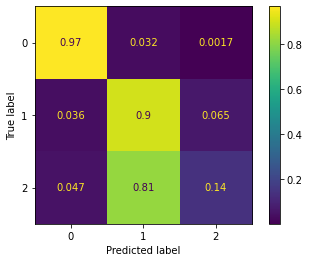

In [34]:
drawConfusionMatrix(actual, prediction, normalize=True)

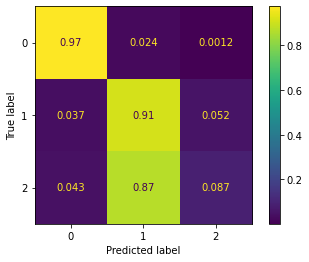

In [35]:
drawConfusionMatrix(actual_14, prediction_14, normalize=True)

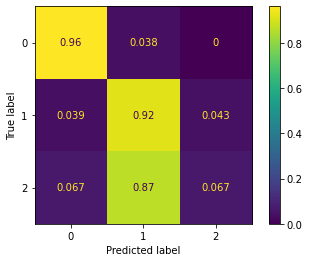

In [36]:
drawConfusionMatrix(actual_21, prediction_21, normalize=True)

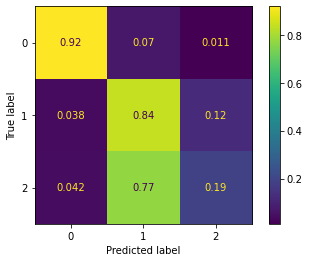

In [37]:
drawConfusionMatrix(actual_25, prediction_25, normalize=True)

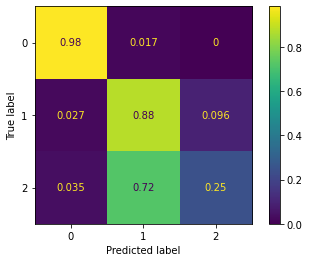

In [39]:
drawConfusionMatrix(actual_28, prediction_28 , normalize=True)

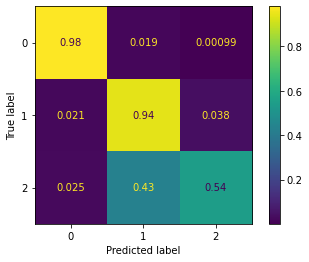

In [41]:
drawConfusionMatrix(actual_28_all, prediction_28_all , normalize=True)